In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange

import burst_tools as bt
import sys
sys.path.append("../../include/")
import hhsignal
import hhtools

# Test with one 

In [2]:
vlfp_t, fs = hhtools.load_vlfp("../data/id%06d_lfp.dat"%(100))
ts = np.arange(len(vlfp_t[0])) / fs

mbin_t = 0.01
wbin_t = 1
flim = (10, 90)

psd_pop = []
for tp in range(2):
    vlfp = vlfp_t[tp+1]
    idt = (ts >= 0.5)
    vlfp = vlfp[idt]
    psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, ts[idt], fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=flim)
    psd_pop.append(psd)

In [36]:
norm_psd = [(psd - np.average(psd, axis=1)[:, np.newaxis])/np.std(psd, axis=1)[:, np.newaxis] for psd in psd_pop]
fcorr = (norm_psd[0] @ norm_psd[1].T) / len(norm_psd[0][0])

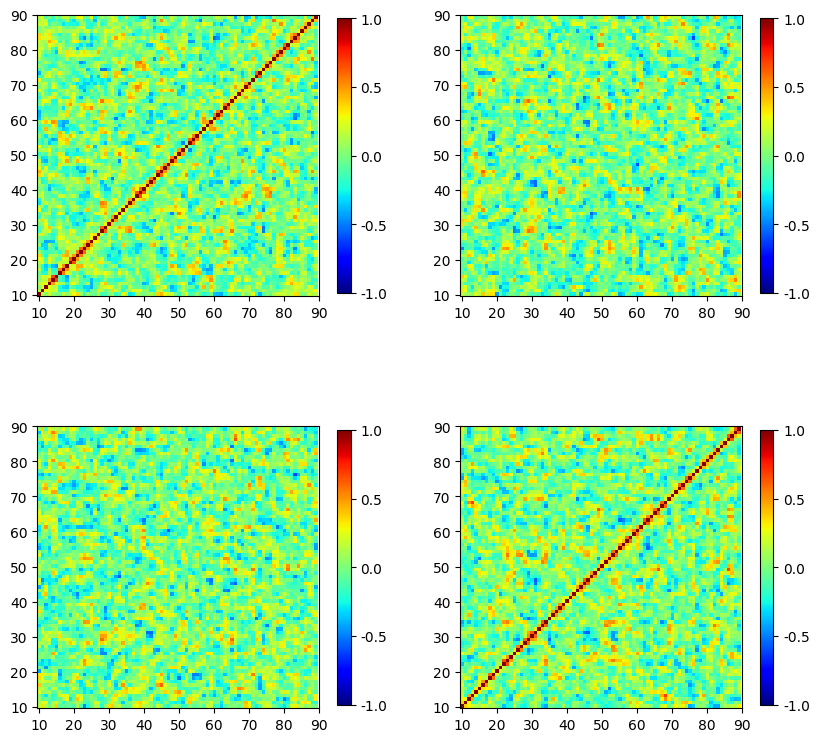

In [52]:
plt.figure(dpi=100, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        fcorr = (norm_psd[i] @ norm_psd[j].T) / len(norm_psd[0][0])
        hhtools.imshow_xy(fcorr, x=fpsd, y=fpsd, cmap="jet", vmin=-1, vmax=1)
        plt.axis("square")
        ft = np.arange(flim[0], flim[1]+5, 10)
        plt.xticks(ft); plt.yticks(ft)
        cbar = plt.colorbar(shrink=0.8, format=lambda x, pos: "{:.1f}".format(x))
        cbar.ax.locator_params(nbins=5)
plt.show()

## Test for all samples in specific cluster 

In [3]:
summary_obj = hhtools.SummaryLoader("../data")
print(summary_obj.num_controls)

[15, 300]


In [34]:
from multiprocess import Pool
from tqdm.notebook import trange


def parfor(func, arr2run, ncore=10):
    from multiprocessing import Pool
    args = [(val, job_id) for job_id, val in enumerate(arr2run)]

    itr_pool = len(arr2run) // ncore
    if itr_pool * ncore < len(arr2run):
        itr_pool += 1
    
    global pfunc
    def pfunc(args):
        return func(args[0]), args[1] # job_id

    outs = []
    for n in trange(itr_pool):
        with Pool(ncore) as p:
            outs.extend(p.map(pfunc, args[ncore*n:ncore*(n+1)]))

    job_id_set = [outs[i][1] for i in range(len(arr2run))]    
    job_sort = np.argsort(job_id_set)
    
    return [outs[i][0] for i in job_sort]


def get_psd_pop(nid):
    vlfp_t, fs = hhtools.load_vlfp("../data/id%06d_lfp.dat"%(nid))
    ts = np.arange(len(vlfp_t[0])) / fs
    idt = (ts >= 0.5)
    psd_set = [[], []]
    psd_set[0], _, _ = hhsignal.get_stfft(vlfp_t[1][idt], ts[idt], fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=flim)
    psd_set[1], fpsd, tpsd = hhsignal.get_stfft(vlfp_t[2][idt], ts[idt], fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=flim)
    # norm_psd = [(psd - np.average(psd, axis=1)[:, np.newaxis])/np.std(psd, axis=1)[:, np.newaxis] for psd in psd_set]
    return psd_set, fpsd, tpsd


def get_norm_psd(psd_set):
    norm_psd_set = np.zeros_like(psd_set)
    for i in range(len(psd_set)):
        for tp in range(len(psd_set[i])):
            psd = psd_set[i][j]
            m = np.average(psd, axis=1)
            s = np.std(psd, axis=1)
            norm_psd_set[i, tp, :, :] = (psd - m[:, np.newaxis]) / s[:, np.newaxis]
    return norm_psd_set


def get_avg_corr_mat(norm_data, ncore=10):
    # 'norm_data' must be the 3-D matrix; 2xNrxNc
    def _get_corr(xsub):
        norm_xsub = [(x - np.average(x, axis=1)[:, np.newaxis]) / np.std(x, axis=1)[:, np.newaxis] for x in xsub]
        
        nr = np.shape(xsub)[1]
        corr_mats = np.zeros([nr, nr, 4])
        for tp in range(4):
            i, j = tp//2, tp%2
            corr_mats[:, :, tp] = (norm_xsub[i] @ norm_xsub[j].T) / np.shape(norm_xsub[0])[1]
        return corr_mats
        
    corr_mats = np.average(parfor(_get_corr, norm_data, ncore=ncore), axis=0)
    return corr_mats
    
    
def draw_corr_map(corrs, fpsd, figsize=(5, 5), dpi=120, vmin=-0.1, vmax=0.1):
    pop_lb = ["F", "S"]
    
    plt.figure(dpi=dpi, figsize=figsize)
    for tp in range(4):
        i, j = tp//2, tp%2
        plt.subplot(2,2,tp+1)
        hhtools.imshow_xy(corrs[:,:,tp], x=fpsd, y=fpsd, cmap="jet", vmin=vmin, vmax=vmax, interpolation="none")
        plt.axis("square")
        ft = np.arange(fpsd[0], fpsd[1]+5, 10)
        plt.xticks(ft); plt.yticks(ft)
        plt.ylabel("frequency (Hz, pop %s)"%(pop_lb[i]), fontsize=13)
        plt.xlabel("frequency (Hz, pop %s)"%(pop_lb[i]), fontsize=13)
        cbar = plt.colorbar(shrink=0.8, format=lambda x, pos: "{:.3f}".format(x))
        cbar.ax.locator_params(nbins=5)
    # plt.suptitle("Cluster %d"%(cid), fontsize=15)
    # plt.tight_layout()

In [6]:
import multifreq_correlation as mc
from importlib import reload
import pickle as pkl
reload(mc)

summary_obj = hhtools.SummaryLoader("../data")
print(summary_obj.num_controls)

with open("./th_data2.pkl", "rb") as f:
    th_psd = pkl.load(f)
print(th_psd.keys())

mc.main(fname_th="./th_data2.pkl", std_min=3.3, std_max=8, std_step=0.1, nmin_width=-1, arange=(0.1, 2.1), da=1)

[15, 300]
dict_keys(['th_psd', 'th_m', 'th_s', 'std_ratio', 'method', 'fdir_data', 'psd_params', 'updated'])


In [14]:
cid = 11

pmaps, bmaps, amp_edges, burst_amps = mc.get_corr_map_cluster(summary_obj, cid, th_psd, ncore=50)

In [17]:
num_b = [np.sum([len(b[0]) for b in burst_amps]),
         np.sum([len(b[1]) for b in burst_amps])]
print(num_b, amp_edges)

[16357, 11932] [0.1 1.1 2.1]


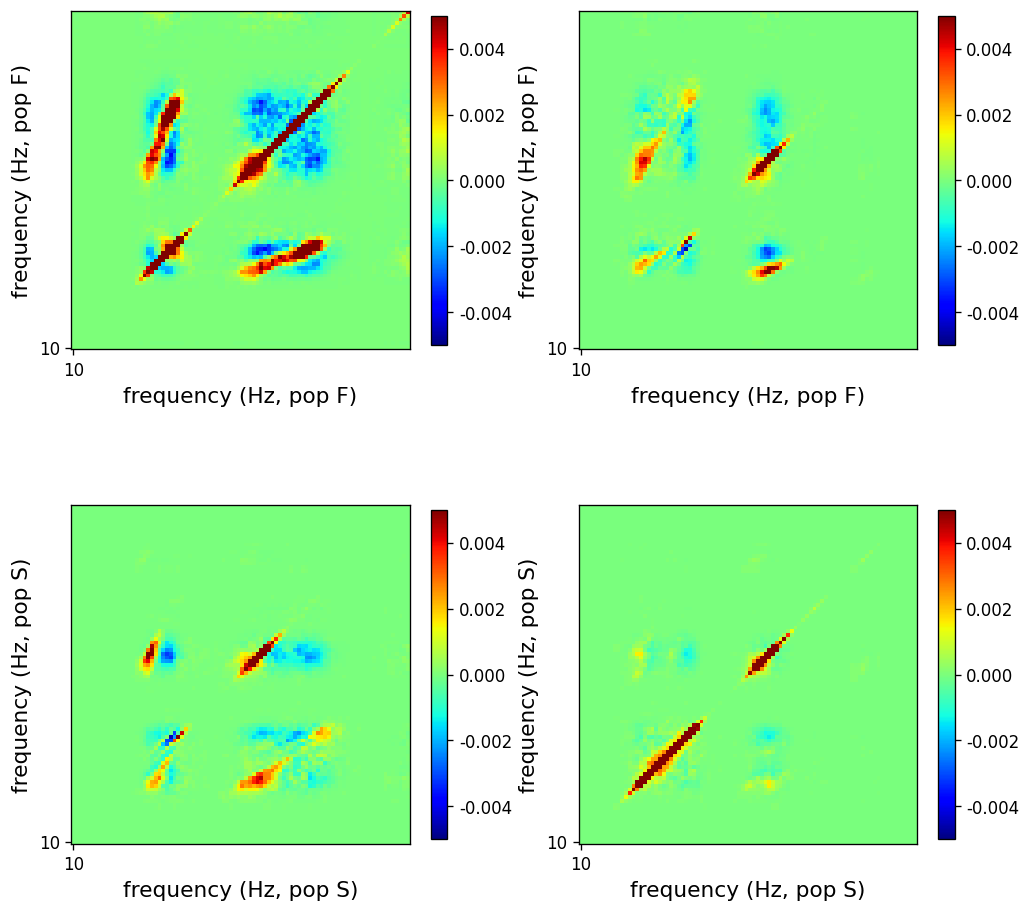

In [43]:
fpsd = np.linspace(10, 100, pmaps.shape[0])
draw_corr_map(bmaps[0], fpsd, figsize=(10, 10), vmin=-0.005, vmax=0.005)

In [20]:
len(bmaps[0])

90

In [16]:
amp_edges

array([0.1, 1.1, 2.1])

In [12]:
num_b

[16357]

In [10]:
len(burst_amps[0])

2

In [187]:


bcorrs = []
burst_maps = []
bamps  = []
for ni in tqdm(range(50)):
    nid = summary_obj.get_id(cid-1, ni)
    fname = os.path.join(summary_obj.fdir, "id%06d_lfp.dat"%(nid))
    th_psd_m = th_psd["th_m"][nid, :]
    th_psd_s = th_psd["th_s"][nid, :]
    
    psd_set, fpsd, tpsd = mc._get_psd_single(fname)
    bmaps, _, _, burst_amps = mc._get_bmap(psd_set, fpsd, th_psd_m, th_psd_s)
    bcorr = mc._get_bcorr_with_amp(bmaps, burst_amps, (0.1, 2))
    
    bcorrs.append(bcorr)
    burst_maps.append(bmaps)
    bamps.append(burst_amps)

  0%|          | 0/50 [00:00<?, ?it/s]

In [189]:
num_b = [np.sum([len(b[0]) for b in bamps]),
         np.sum([len(b[1]) for b in bamps])]

[2510, 2015]

In [188]:
len(bamps)

50

In [173]:
cid = 11
ni = 0

nid = summary_obj.get_id(cid-1, ni)

fname = os.path.join(summary_obj.fdir, "id%06d_lfp.dat"%(nid))
th_psd_m = th_psd["th_m"][nid, :]
th_psd_s = th_psd["th_s"][nid, :]

psd_set, fpsd, tpsd = mc._get_psd_single(fname)

bmaps, _, _, burst_amps = mc._get_bmap(psd_set, fpsd, th_psd_m, th_psd_s)
# _, _, _, btmp = mc.get_corr_map(psd_set, fpsd, th_psd_m=th_m, th_psd_s=th_s)

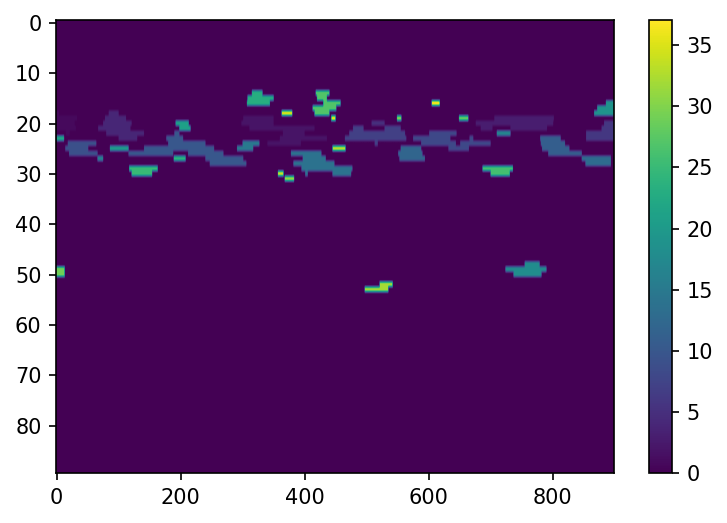

In [177]:
plt.figure(dpi=150)
plt.imshow(bmaps[1], aspect="auto")
plt.colorbar()

In [181]:
bcorr = mc._get_bcorr_with_amp(bmaps, burst_amps, (0.1, 2))

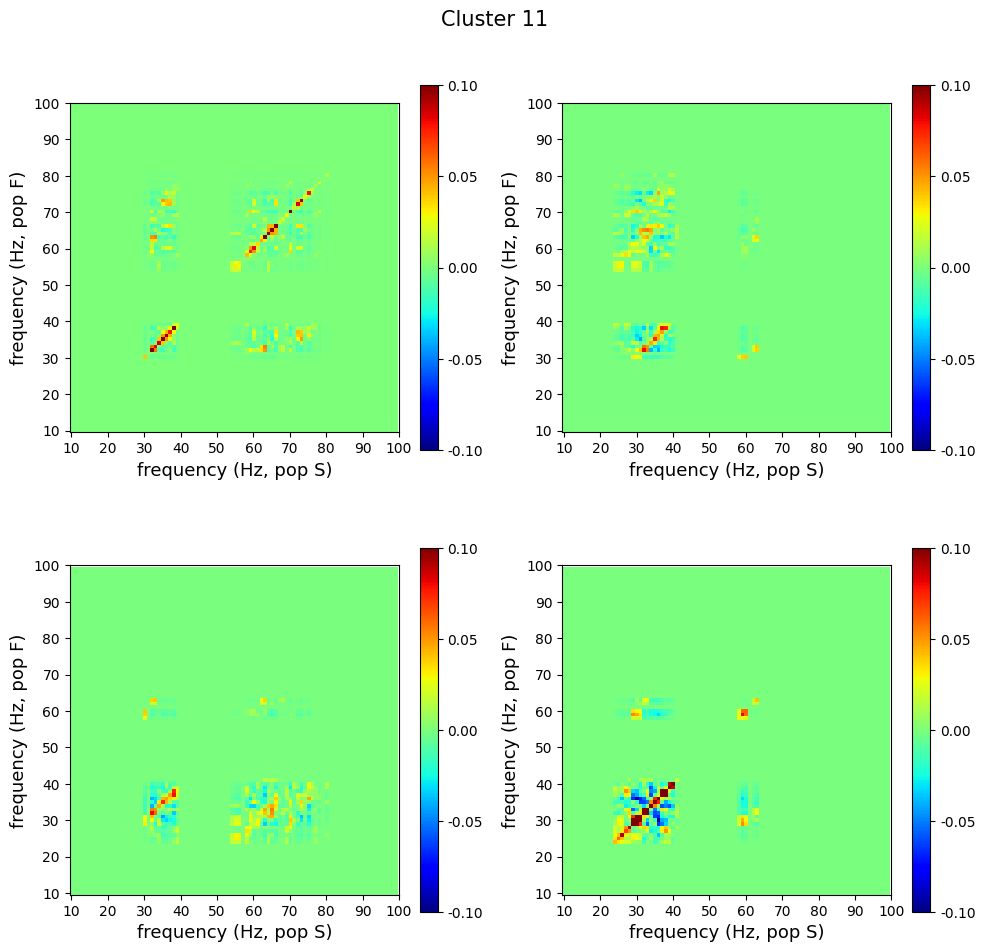

In [186]:
plt.figure(dpi=100, figsize=(10, 10))
for tp in range(4):
    i, j = tp//2, tp%2
    plt.subplot(2,2,tp+1)
    hhtools.imshow_xy(bcorr[:,:,tp], x=fpsd, y=fpsd, cmap="jet", vmin=-0.1, vmax=0.1, interpolation="none")
    plt.axis("square")
    ft = np.arange(flim[0], flim[1]+5, 10)
    plt.xticks(ft); plt.yticks(ft)
    plt.xlabel("frequency (Hz, pop S)", fontsize=13)
    plt.ylabel("frequency (Hz, pop F)", fontsize=13)
    cbar = plt.colorbar(shrink=0.8, format=lambda x, pos: "{:.2f}".format(x))
    cbar.ax.locator_params(nbins=5)
plt.suptitle("Cluster %d"%(cid), fontsize=15)
plt.tight_layout()

In [182]:
len(bcorr)

90

In [174]:
len(bmaps)

2

In [157]:
from tqdm.notebook import tqdm

pmaps = []
for cid in tqdm(range(1, 16)):
    pmaps.append(mc.get_corr_map_cluster(summary_obj, cid, th_psd, ncore=50))

  0%|          | 0/15 [00:00<?, ?it/s]

In [169]:
flim = (10, 100)

for nc in tqdm(range(15)):
    plt.figure(dpi=100, figsize=(10, 10))
    for tp in range(4):
        i, j = tp//2, tp%2
        plt.subplot(2,2,tp+1)
        hhtools.imshow_xy(pmaps[nc][:,:,tp], x=fpsd, y=fpsd, cmap="jet", vmin=-0.1, vmax=0.1, interpolation="none")
        plt.axis("square")
        ft = np.arange(flim[0], flim[1]+5, 10)
        plt.xticks(ft); plt.yticks(ft)
        plt.xlabel("frequency (Hz, pop S)", fontsize=13)
        plt.ylabel("frequency (Hz, pop F)", fontsize=13)
        cbar = plt.colorbar(shrink=0.8, format=lambda x, pos: "{:.2f}".format(x))
        cbar.ax.locator_params(nbins=5)
    plt.suptitle("Cluster %d"%(nc+1), fontsize=15)
    plt.tight_layout()
    plt.savefig("./joint_maps/pmaps_%02d.png"%(nc+1), dpi=150)
    plt.clf()
    

  0%|          | 0/15 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [ ]:
pmaps = []
for cid in ran

In [134]:
cid = 5

psd_corr_map, b_corr_map, amp_edges, bamp = mc.get_corr_map_cluster(summary_obj, cid, th_psd, ncore=20)

/home/jungyoung/Project/hh_neuralnet/gen_three_pop_samples/multifreq_burst/multifreq_correlation.py:222: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


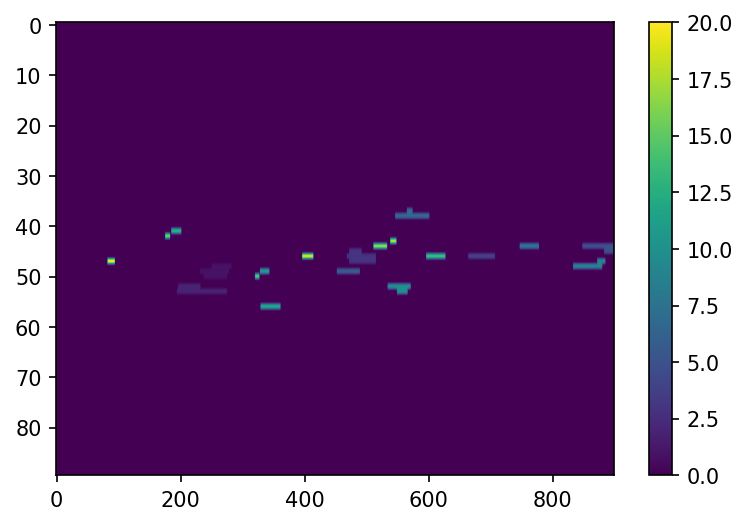

In [117]:
plt.figure(dpi=150)
plt.imshow(bmaps[0][0], aspect="auto")
plt.colorbar()

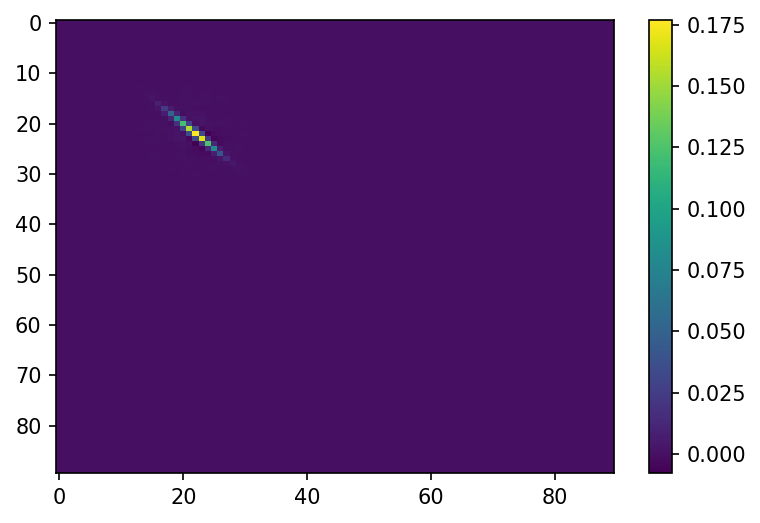

In [125]:
plt.figure(dpi=150)
plt.imshow(b_corr_map[0][:,:,3], aspect="auto")
plt.colorbar()

In [118]:
n = 0

nid = summary_obj.get_id(cid, n)
fname = os.path.join(summary_obj.fdir, "id%06d_lfp.dat"%(nid))

th_m = th_psd["th_m"][nid, :]
th_s = th_psd["th_s"][nid, :]

psd_set, fpsd, tpsd = mc._get_psd_single(fname)
_, _, _, btmp = mc.get_corr_map(psd_set, fpsd, th_psd_m=th_m, th_psd_s=th_s)

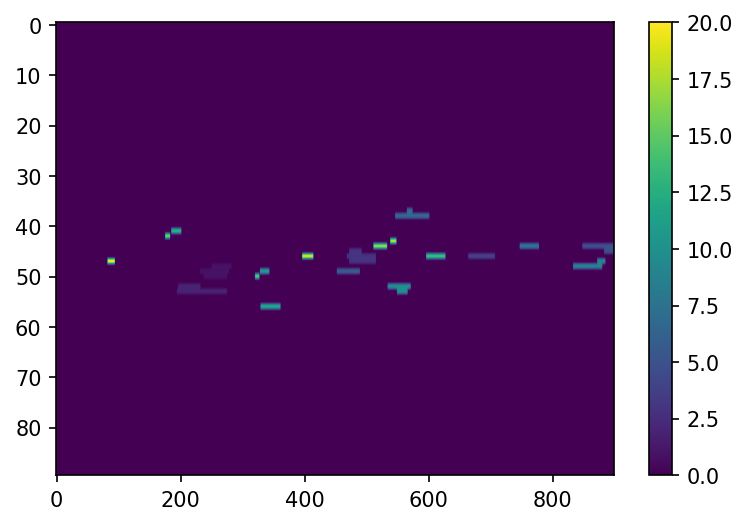

In [120]:
plt.figure(dpi=150)
plt.imshow(btmp[0], aspect="auto")
plt.colorbar()

## Test 

In [33]:
import os

cid = 11
n = 0

summary_obj = hhtools.SummaryLoader("../data")
print(summary_obj.num_controls)

th_m = th_psd["th_m"][nid, :]
th_s = th_psd["th_s"][nid, :]

nid = summary_obj.get_id(cid, n)
fname = os.path.join(summary_obj.fdir, "id%06d_lfp.dat"%(nid))

[15, 300]


In [30]:
psd_set, fpsd, tpsd = mc._get_psd_single(fname)
psd_corr_map, b_corr_map, edges, bmaps = mc.get_corr_map(psd_set, fpsd, th_psd_m=th_m, th_psd_s=th_s)

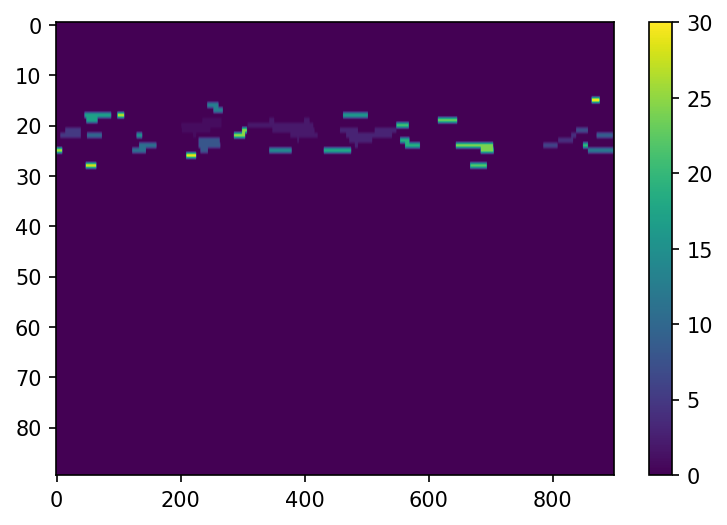

In [31]:
plt.figure(dpi=150)
plt.imshow(bmaps[1], aspect="auto")
plt.colorbar()

AttributeError: Can't pickle local object 'get_corr_map_cluster.<locals>._get_cmap_cluster'

In [18]:
outs = res[3]

In [22]:
bmaps = np.array([outs[n][3] for n in range(len(outs))])
print(bmaps.shape)

(300, 2, 90, 900)


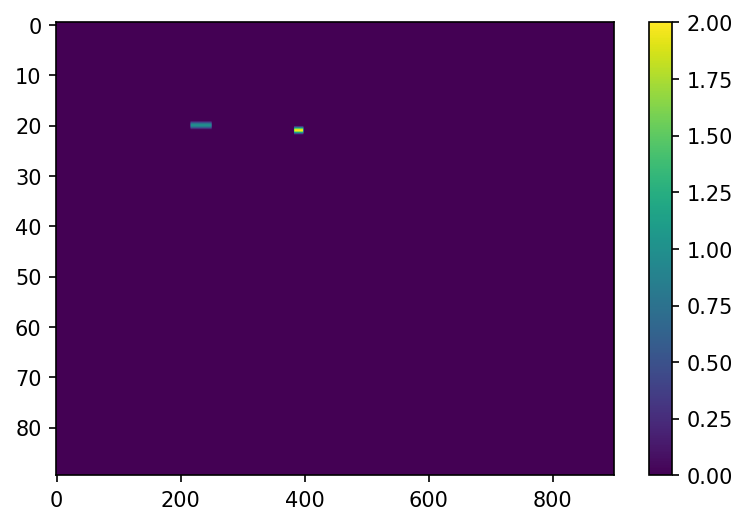

In [28]:
plt.figure(dpi=150)
plt.imshow(bmaps[0, 1, :, :], aspect="auto")
plt.colorbar()

In [21]:
len(bmaps)

300

In [17]:
len(res)

4

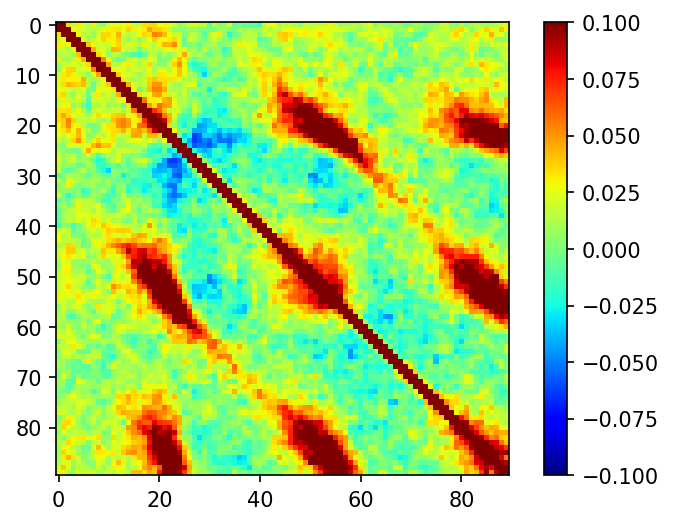

In [382]:
plt.figure(dpi=150)
plt.imshow(res[0][:,:,3], vmin=-0.1, vmax=0.1, cmap="jet")
plt.colorbar()

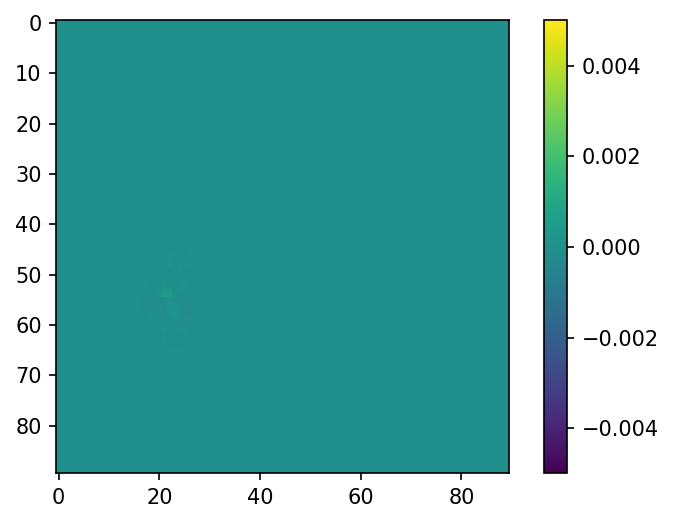

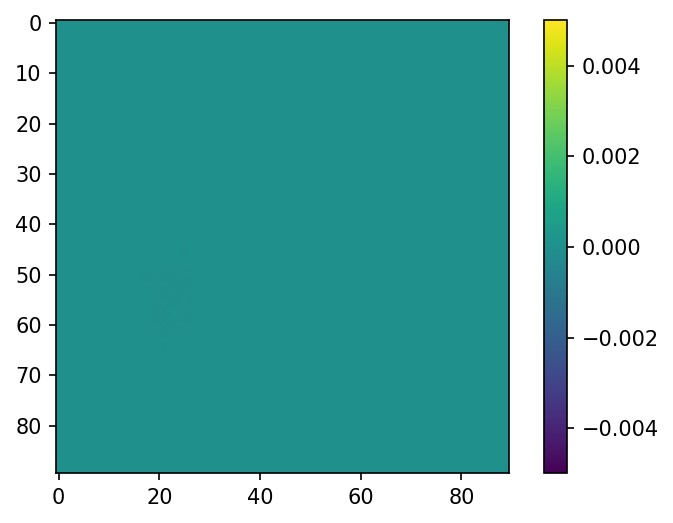

IndexError: index 2 is out of bounds for axis 0 with size 2

<Figure size 900x600 with 0 Axes>

In [379]:
for i in range(3):
    plt.figure(dpi=150)
    plt.imshow(res[1][i][:,:,1], vmin=-0.005, vmax=0.005)
    plt.colorbar()
    plt.show()

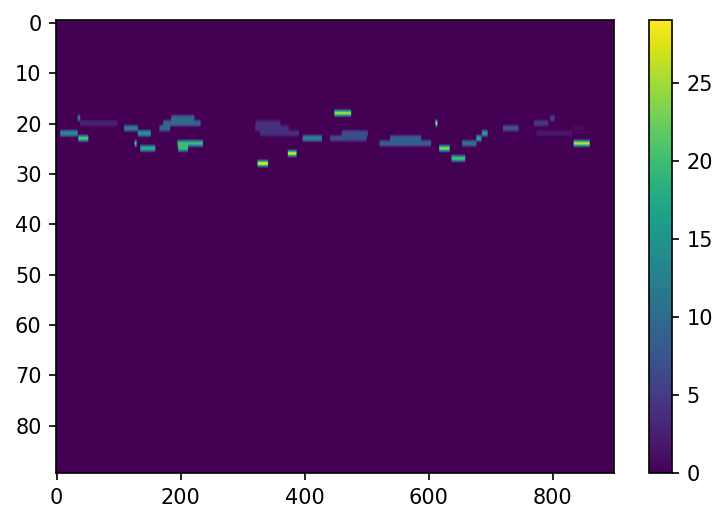

In [511]:
import os

cid = 5
n = 0

nid = summary_obj.get_id(cid, n)
fname = os.path.join(summary_obj.fdir, "id%06d_lfp.dat"%(nid))

mbin_t = th_psd["psd_params"]["mbin_t"]
wbin_t = th_psd["psd_params"]["wbin_t"]
flim = th_psd["psd_params"]["flim"]
fs = 2000


vlfp_t, fs = hhtools.load_vlfp(fname)
ts = np.arange(len(vlfp_t[0])) / fs
idt = (ts >= 0.5)
psd_set = [[], []]

tp = 1

psd, fpsd, _ = hhsignal.get_stfft(vlfp_t[tp+1][idt], ts[idt], fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=flim)

th_m = th_psd["th_m"][nid, tp]
th_s = th_psd["th_s"][nid, tp]
bmap = bt.find_blob_filtration(psd, th_m, th_s,
                                            std_min=3.3, std_max=8, std_step=0.1,
                                            nmin_width=1)

plt.figure(dpi=150)
plt.imshow(bmap, aspect="auto")
plt.colorbar()

In [512]:
bmap = bt.find_blob_filtration(psd, th_m, th_s,
                                            std_min=3.3, std_max=8, std_step=0.1,
                                            nmin_width=1)
burst_f, burst_range, burst_amp = bt.extract_burst_attrib(psd, fpsd, bmap)

In [513]:
psd_set, fpsd, tpsd = mc._get_psd_single(fname)
bmaps, _, _, burst_amps = mc._get_bmap(psd_set, fpsd, th_psd["th_m"][nid, :], th_psd["th_s"][nid, :])

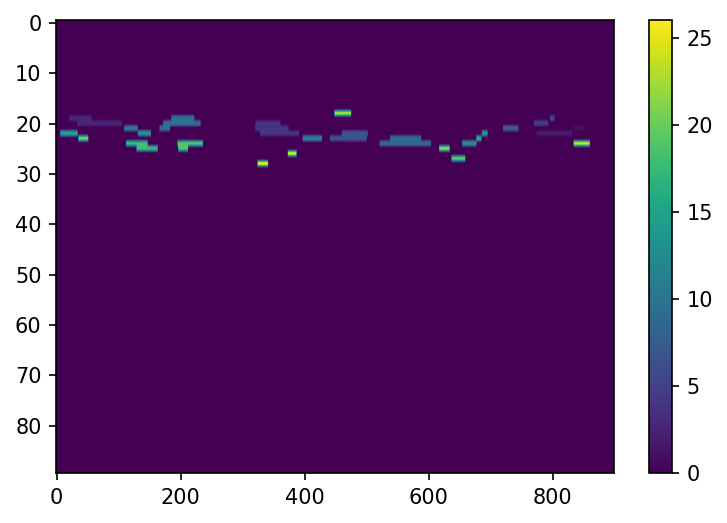

In [514]:
plt.figure(dpi=150)
plt.imshow(bmaps[tp], aspect="auto")
plt.colorbar()

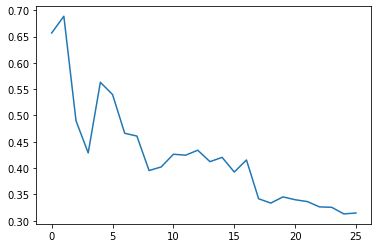

In [524]:
plt.plot(burst_amps[1])

In [519]:
psd_corr_map, b_corr_map, edges, bmaps_tp = mc.get_corr_map(psd_set, fpsd, th_psd_m=th_psd["th_m"][nid, :], th_psd_s=th_psd["th_s"][nid, :])

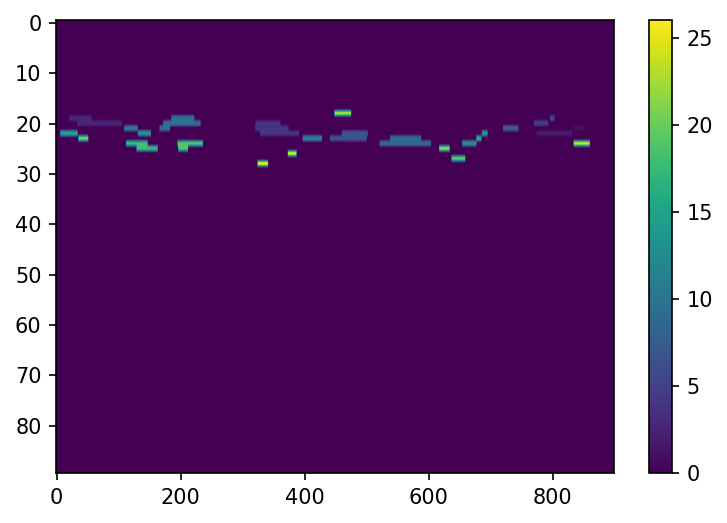

In [521]:
plt.figure(dpi=150)
plt.imshow(bmaps_tp[1], aspect="auto")
plt.colorbar()

In [525]:
bcmap = mc._get_bcorr_with_amp(bmaps, burst_amps, (0, 3))

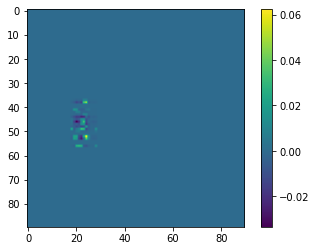

In [531]:
plt.imshow(bcmap[:,:,1])
plt.colorbar()

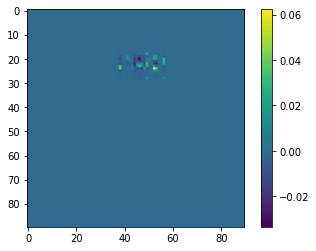

In [509]:
plt.imshow(b_corr_map[0][:,:,2])
plt.colorbar()

In [458]:
from multiprocessing import Pool

cid = 11

args = []
for n in range(50):
    nid = summary_obj.get_id(cid, n)
    fname = os.path.join(summary_obj.fdir, "id%06d_lfp.dat"%(nid))
    args.append((fname, th_psd["th_m"][nid, :], th_psd["th_s"][nid, :]))
    
with Pool(30) as p:
    outs = p.map(mc._get_cmap_cluster, args)

In [466]:
nn = 0

psd_set, fpsd, tpsd = mc._get_psd_single(args[nn][0])
bmaps, _, _, burst_amps = mc._get_bmap(psd_set, fpsd, args[nn][1], args[nn][2])

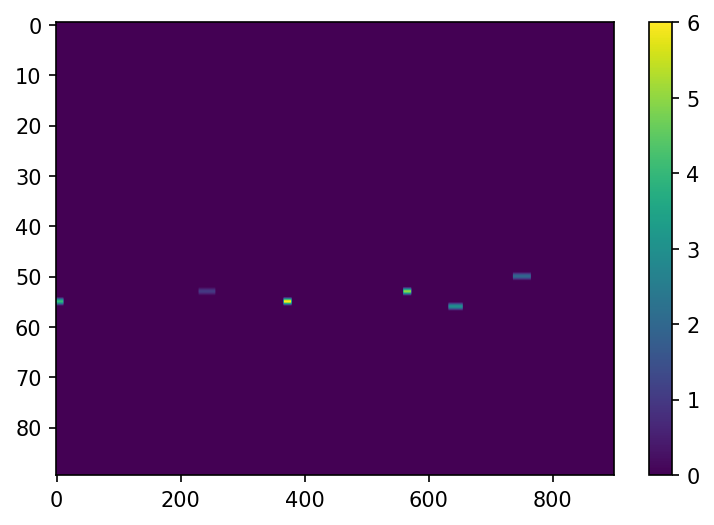

In [467]:
tp = 0

plt.figure(dpi=150)
pth = th_psd["th_m"][nid, tp] + 3.3* th_psd["th_s"][nid, tp]
plt.imshow(bmaps[0], aspect="auto")
plt.colorbar()

In [444]:
mc.check_params("std_step")

0.1


In [445]:
cid = 4

nid = summary_obj.get_id(cid, n)
fname = os.path.join(summary_obj.fdir, "id%06d_lfp.dat"%(nid))

psd_set, fpsd, tpsd = mc._get_psd_single(fname)
bmaps, _, _, burst_amps = mc._get_bmap(psd_set, fpsd, th_psd["th_m"][nid, :], th_psd["th_s"][nid, :])

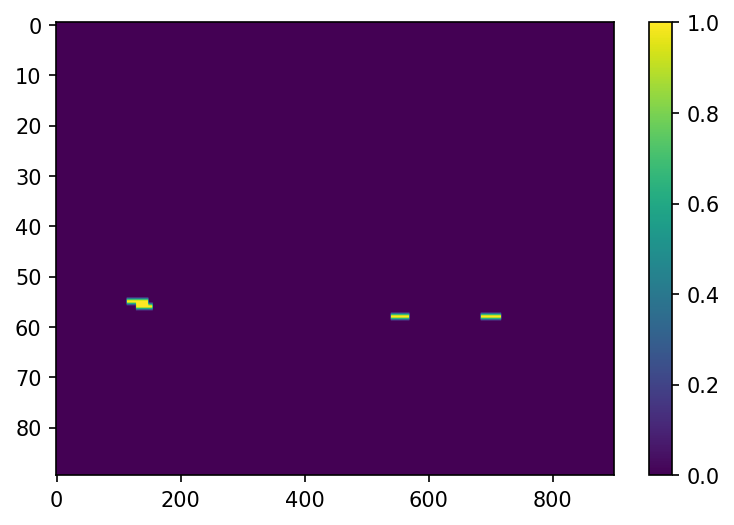

In [475]:
tp = 0

plt.figure(dpi=150)
pth = th_psd["th_m"][nid, tp] + 3.2 * th_psd["th_s"][nid, tp]
plt.imshow(psd_set[tp] > pth, aspect="auto")
plt.colorbar()

In [431]:
bmaps[0].shape

(90, 900)

In [424]:
args[0][1]

array([0.1244563, 0.1244563])

In [425]:
args[0][2]

array([0.14091042, 0.14091042])

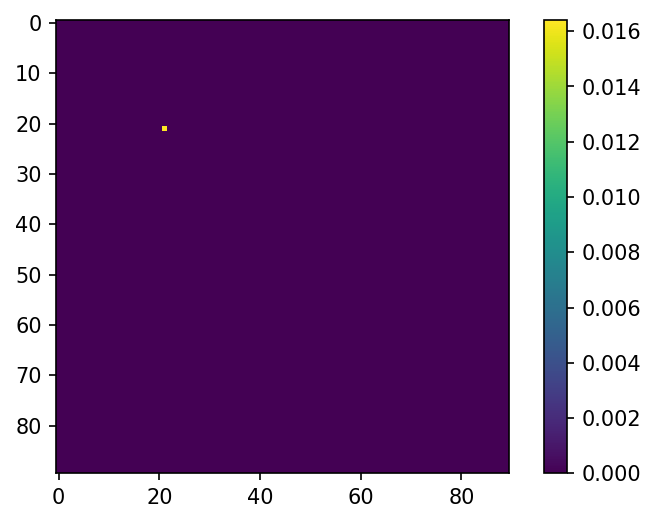

In [423]:
plt.figure(dpi=150)
plt.imshow(res[1][0][:,:,3])
plt.colorbar()

In [409]:
bmaps = [outs[n][1] for n in range(50)]

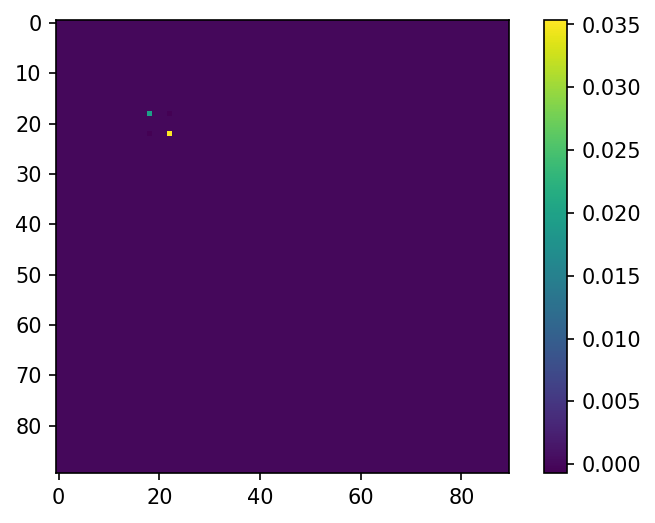

In [418]:
plt.figure(dpi=150)
plt.imshow(bmaps[4][0][:,:,3])
plt.colorbar()

In [401]:
Pool

NameError: name 'Pool' is not defined

In [400]:
fname

'../data/id003349_lfp.dat'

In [383]:


psd_set, fpsd, tpsd = mc._get_psd_single(fname)
bmaps, _, _, burst_amps = mc._get_bmap(psd_set, fpsd, th_psd["th_m"][nid, :], th_psd["th_s"][nid, :])

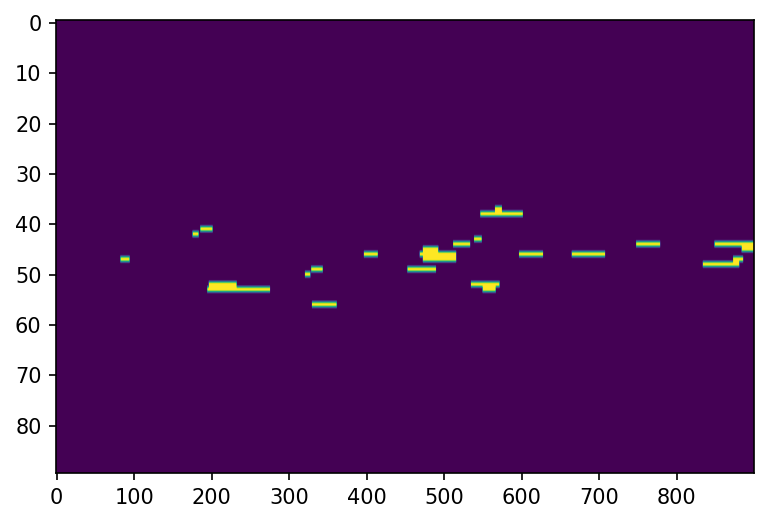

In [385]:
plt.figure(dpi=150)
plt.imshow(bsets[0], aspect="auto")

In [389]:
edges = np.arange(0.1, 2.11, 1)

In [392]:
na = 0
bc_map = mc._get_bcorr_with_amp(bmaps, burst_amps, edges[na:na+2])

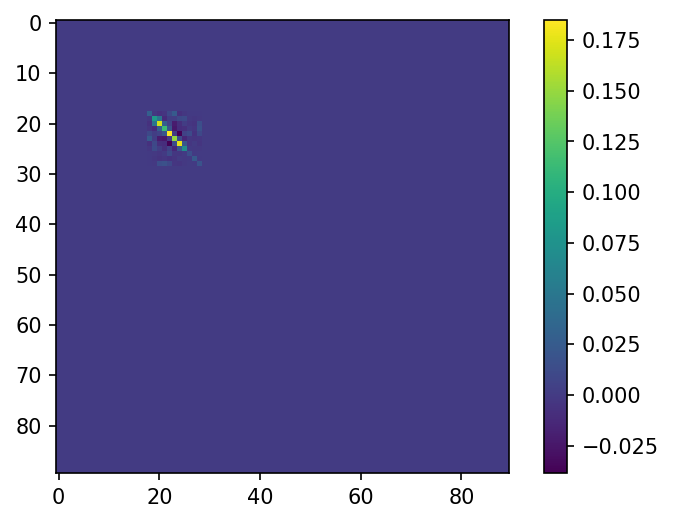

In [398]:
plt.figure(dpi=150)
plt.imshow(bc_map[:,:,3])
plt.colorbar()

In [334]:
bsets = [(b > 1).astype(int) for b in bmaps]
p_burst_corr = mc._get_corr(bsets)
p_indep = [np.sum(b, axis=1)[:, np.newaxis]/b.shape[1] for b in bsets]

# dx = p_burst_corr - p_indep_map

SyntaxError: invalid syntax (<ipython-input-334-6accb1f7d689>, line 4)

In [336]:
pbc, pi = mc._get_burst_corr(bmaps)

In [337]:
dx =pbc - pi

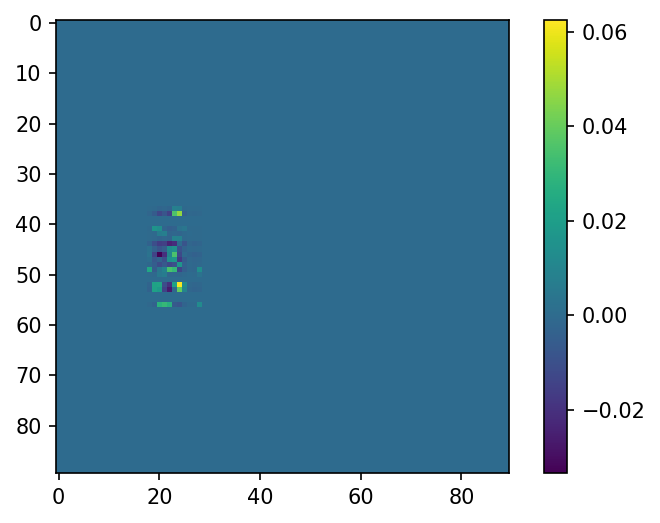

In [339]:
plt.figure(dpi=150)
plt.imshow(dx[:,:,1])
plt.colorbar()

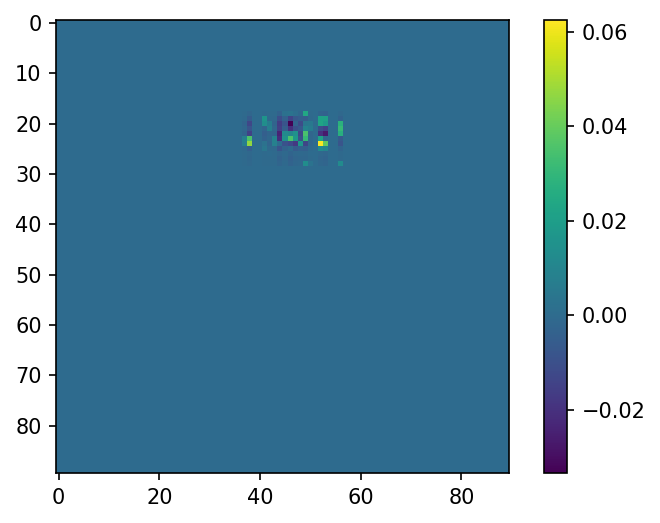

In [338]:
plt.figure(dpi=150)
plt.imshow(dx[:,:,2])
plt.colorbar()

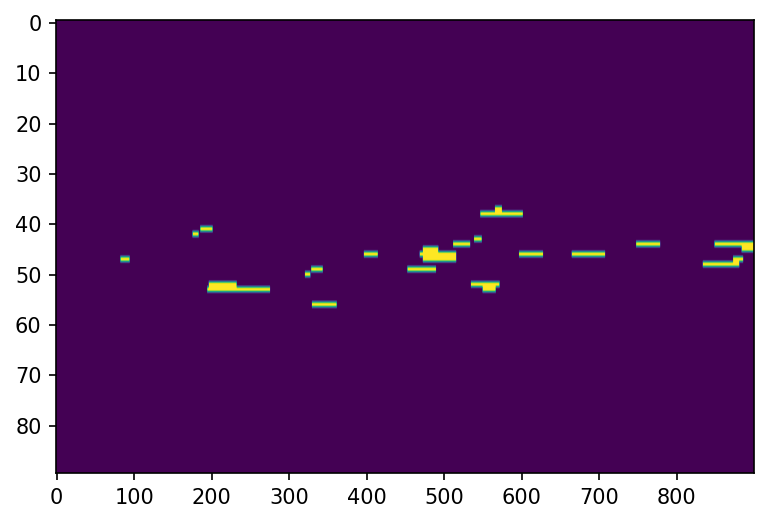

In [315]:
plt.figure(dpi=150)
plt.imshow(bsets[0], aspect="auto")

In [316]:
bcorr = bsets[0].astype(int) @ bsets[0].astype(int).T

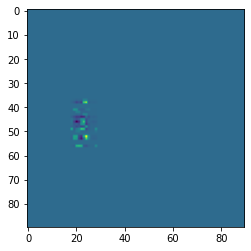

In [323]:
plt.imshow(dx[:,:,1])

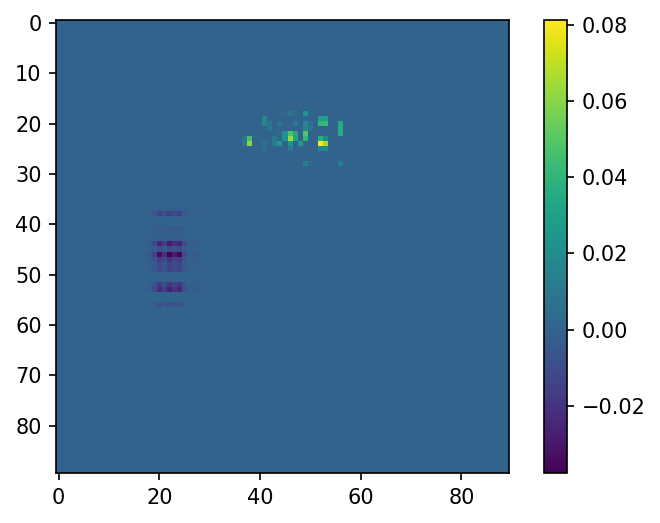

In [322]:
plt.figure(dpi=150)
plt.imshow(dx[:,:,2])
plt.colorbar()

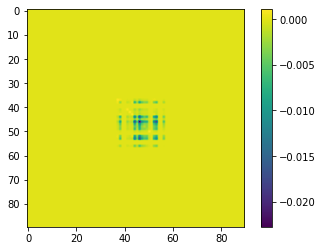

In [299]:
plt.imshow(dx[:,:,0])
plt.colorbar()

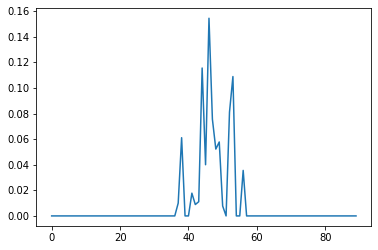

In [287]:
plt.plot(p_indep[0][:,0])

In [288]:
p_indep_map = mc._get_corr(p_indep)

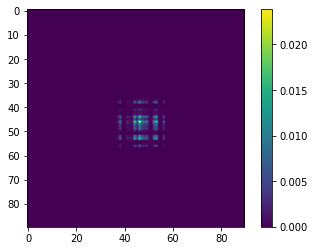

In [292]:
plt.imshow(p_indep_map[:,:,0])
plt.colorbar()

In [290]:
p_indep_map.shape

(90, 90, 4)

In [ ]:
th_psd

In [223]:
th_psd["psd_params"]

{'mbin_t': 0.01, 'wbin_t': 1, 'flim': (10, 100)}

In [144]:
nid = 10
psd_set, fpsd, tpsd = mc._get_psd_single(nid)
th_m = th_psd["th_m"][nid, :]
th_s = th_psd["th_s"][nid, :]

In [145]:
psd_corr_map = mc._get_psd_corr(psd_set)

In [103]:
bmaps, _, _, burst_amps = mc._get_bmap(psd_set, fpsd, th_m, th_s, 
                                       std_min=3.2, std_max=8, std_step=0.1,
                                       nmin_width=1)


In [105]:
bmaps2 = mc._get_bcorr_with_amp(bmaps, burst_amps, [0.1, 0.2])

In [146]:
pmap, bmap, edges = mc.get_corr_map(psd_set, fpsd,  th_m, th_s, 
                                       std_min=3.2, std_max=8, std_step=0.1,
                                       nmin_width=1, arange=[0.1, 2], da=0.4)

In [173]:
from typing import NamedTuple
from dataclasses import dataclass

In [167]:
class tmp(NamedTuple):
    x1: int = 2
    x2: int = 1

In [171]:
a = tmp(x1=3.2, x2=3)

In [188]:
from typing import Tuple
@dataclass
class mfoConfig:
    mbin_t: float = 0.1
    wbin_t: float = 1
    flim: Tuple[float, float] = (10, 20)
    fdir: str = "./data2"
    std_min: float = 3.3
    std_max: float = 8
    std_step: float = 0.1
    nmin_width: float = -1

In [192]:
@dataclass
class mfoConfig:
    mbin_t: float = 0.1
    wbin_t: float = 1
    flim: Tuple[float, float] = (10, 20)
    fdir: str = "./data2"
    std_min: float = 3.3
    std_max: float = 8
    std_step: float = 0.1
    nmin_width: float = -1

In [191]:
obj.flim = (20, 8)

In [195]:
obj = mfoConfig()
globals()["a"] = 1

In [197]:
del a

In [198]:
def test(**kwargs):
    for k, v in kwargs.items():
        globals()[k] = v

In [199]:
test(a=1)

In [216]:
reload(mc)

<module 'multifreq_correlation' from '/home/jungyoung/Project/hh_neuralnet/gen_three_pop_samples/multifreq_burst/multifreq_correlation.py'>

In [206]:
obj = mc.mfoConfig(mbin_t=1, wbin_t=1000)

In [215]:
vars(obj)

{'mbin_t': 1,
 'wbin_t': 1000,
 'flim': (10, 20),
 'fdir': './data2',
 'std_min': 3.3,
 'std_max': 8,
 'std_step': 0.1,
 'nmin_width': -1}

In [219]:
reload(mc)

obj = mc.mfoConfig(mbin_t=1, wbin_t=1000)
mc.config_params(obj)
mc.check_params()

1 1000 (10, 20) ./data2


In [ ]:
th_psd

In [222]:
th_psd["params"]

KeyError: 'params'

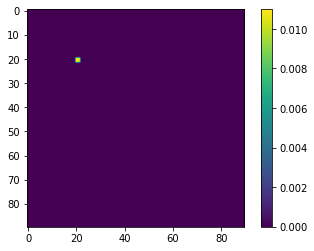

In [160]:
plt.imshow(bmap[4][:,:,3])
plt.colorbar()

In [109]:
bmap[0].shape

(90, 90, 4)

In [96]:
plt.imshow(bmap[0][:,:,0])

TypeError: tuple indices must be integers or slices, not tuple

In [65]:
np.shape(bmaps)

(2, 90, 90)

In [64]:
bmaps_c.shape

(2, 90, 90)

In [53]:
bmaps2.shape

(90, 90, 4)

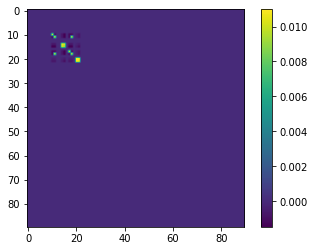

In [59]:
plt.imshow(bmaps2[:,:,3])
plt.colorbar()

In [25]:
tp = 1
bmap = bt.find_blob_filtration(psd_set[tp], th_m[tp], th_s[tp],
                                            std_min=3.2, std_max=8, std_step=0.1,
                                            nmin_width=1)
burst_f, burst_range, burst_amp = bt.extract_burst_attrib(psd_set[tp], fpsd, bmap)

dtype('int64')

In [49]:
cid = 5

mbin_t = 0.01
wbin_t = 1
flim = (10, 100)

nid_set = [summary_obj.get_id(cid, n) for n in range(summary_obj.num_controls[1])]
results = parfor(get_norm_psd_pop, nid_set, ncore=50)

psd_set = [results[i][0] for i in range(len(results))]
fpsd, tpsd = results[0][1], results[0][2]

# norm_psd_set = get_norm_psd(psd_set)
corr_mats = get_avg_corr_mat(psd_set, ncore=50)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [69]:
psd_set.shape

AttributeError: 'list' object has no attribute 'shape'

dict_keys(['th_psd', 'th_m', 'th_s', 'std_ratio', 'method', 'fdir_data', 'psd_params', 'updated'])


In [62]:
n = 0

burst_maps = [[], []]
for tp in range(2):
    burst_maps[tp] = bt.find_blob_filtration(psd_set[n][tp], th_psd["th_m"][nid_set[n], tp], th_psd["th_s"][nid_set[n], tp],
                                                    std_min=3.3, std_max=8, std_step=0.1,
                                                    nmin_width=1)

In [73]:
reload(mc)
pmap = mc._get_burst_corr(burst_maps)

In [76]:
np.min(pmap), np.max(pmap)

(-0.16698888888888885, -0.02072716049382716)

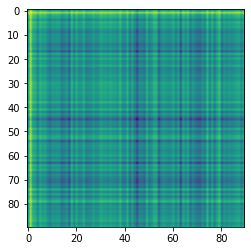

In [75]:
plt.imshow(pmap[:,:,0])

In [65]:
bmaps = [b > 0 for b in burst_maps]

corr_mat = bmaps[0] @ bmaps[1].T

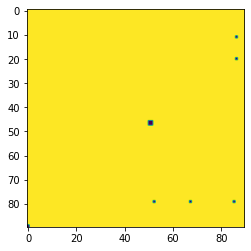

In [66]:
plt.imshow(corr_mat)

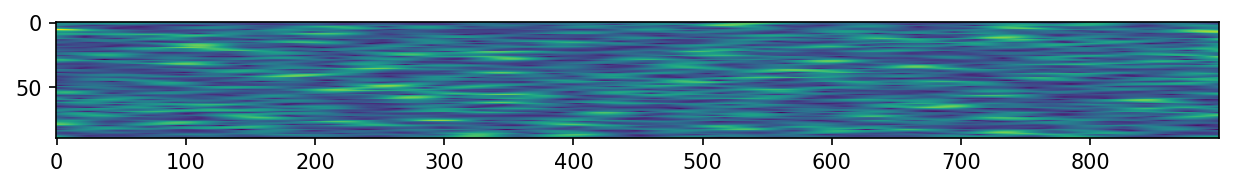

In [60]:
plt.figure(dpi=150, figsize=(10, 6))
plt.imshow(psd_set[0][0])
plt.show()

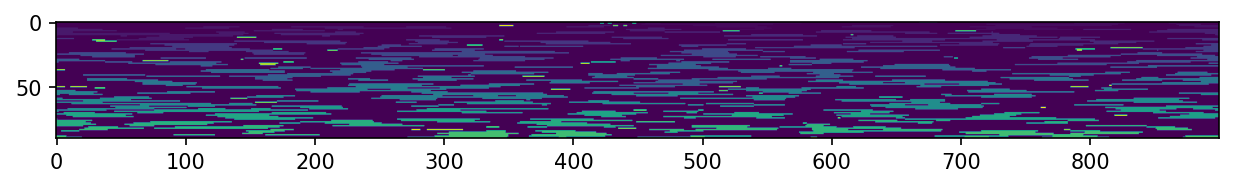

In [63]:
plt.figure(dpi=150, figsize=(10, 6))
plt.imshow(burst_maps[0])
plt.show()

In [ ]:
bt.find_blob_filtration(psd

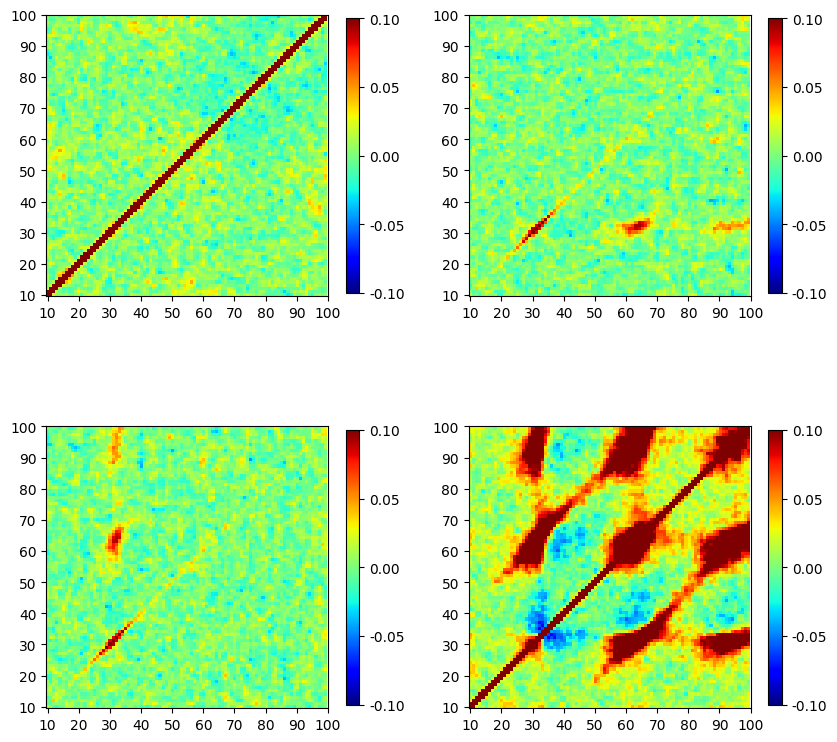

In [33]:
plt.figure(dpi=100, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        hhtools.imshow_xy(corr_mats[:,:,2*i+j], x=fpsd, y=fpsd, cmap="jet", vmin=-0.1, vmax=0.1, interpolation="none")
        plt.axis("square")
        ft = np.arange(flim[0], flim[1]+5, 10)
        plt.xticks(ft); plt.yticks(ft)
        cbar = plt.colorbar(shrink=0.8, format=lambda x, pos: "{:.2f}".format(x))
        cbar.ax.locator_params(nbins=5)
plt.show()

In [34]:
# cid = 5

# mbin_t = 0.01
# wbin_t = 1
# flim = (10, 100)

def get_norm_psd_pop(nid):
    vlfp_t, fs = hhtools.load_vlfp("../data/id%06d_lfp.dat"%(nid))
    ts = np.arange(len(vlfp_t[0])) / fs
    idt = (ts >= 0.5)
    psd_set = [[], []]
    psd_set[0], _, _ = hhsignal.get_stfft(vlfp_t[1][idt], ts[idt], fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=flim)
    psd_set[1], fpsd, tpsd = hhsignal.get_stfft(vlfp_t[2][idt], ts[idt], fs, mbin_t=mbin_t, wbin_t=wbin_t, frange=flim)
    norm_psd = [(psd - np.average(psd, axis=1)[:, np.newaxis])/np.std(psd, axis=1)[:, np.newaxis] for psd in psd_set]
    return norm_psd, fpsd, tpsd

psd_corr_mat = [[[], []],
                [[], []]]
num_itr = summary_obj.num_controls[1]
for n in trange(num_itr):
    nid = summary_obj.get_id(cid, n)
    norm_psd, fpsd, tpsd = get_norm_psd_pop(nid)
    for tp in range(4):
        i, j = tp//2, tp%2
        if len(psd_corr_mat[i][j]) == 0:
            psd_corr_mat[i][j] = (norm_psd[i] @ norm_psd[j].T) / len(norm_psd[0][0])
        else: 
            psd_corr_mat[i][j] += (norm_psd[i] @ norm_psd[j].T) / len(norm_psd[0][0])

for tp in range(4):
    i, j = tp//2, tp%2
    psd_corr_mat[i][j] /= num_itr

  0%|          | 0/300 [00:00<?, ?it/s]

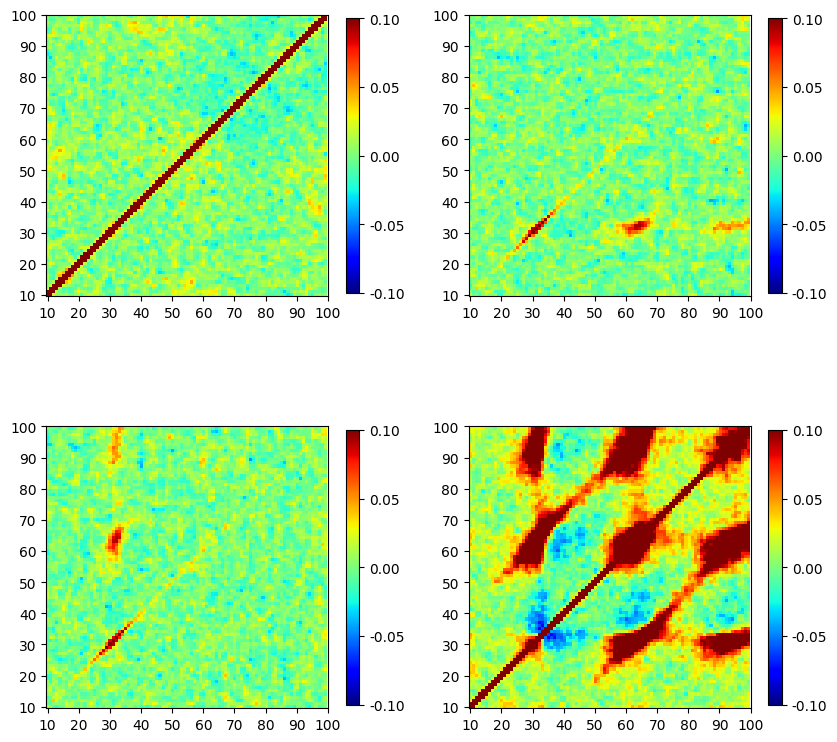

In [35]:
plt.figure(dpi=100, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        hhtools.imshow_xy(psd_corr_mat[i][j], x=fpsd, y=fpsd, cmap="jet", vmin=-0.1, vmax=0.1, interpolation="none")
        plt.axis("square")
        ft = np.arange(flim[0], flim[1]+5, 10)
        plt.xticks(ft); plt.yticks(ft)
        cbar = plt.colorbar(shrink=0.8, format=lambda x, pos: "{:.2f}".format(x))
        cbar.ax.locator_params(nbins=5)
plt.show()

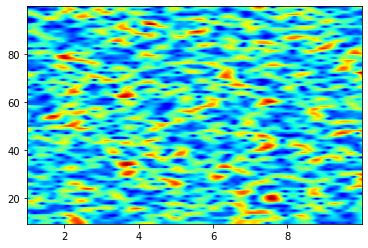

In [38]:
plt.figure()
hhtools.imshow_xy(norm_psd[0], x=tpsd, y=fpsd, cmap="jet")
plt.show()

In [33]:
plt.imshow(psd)

NameError: name 'psd' is not defined

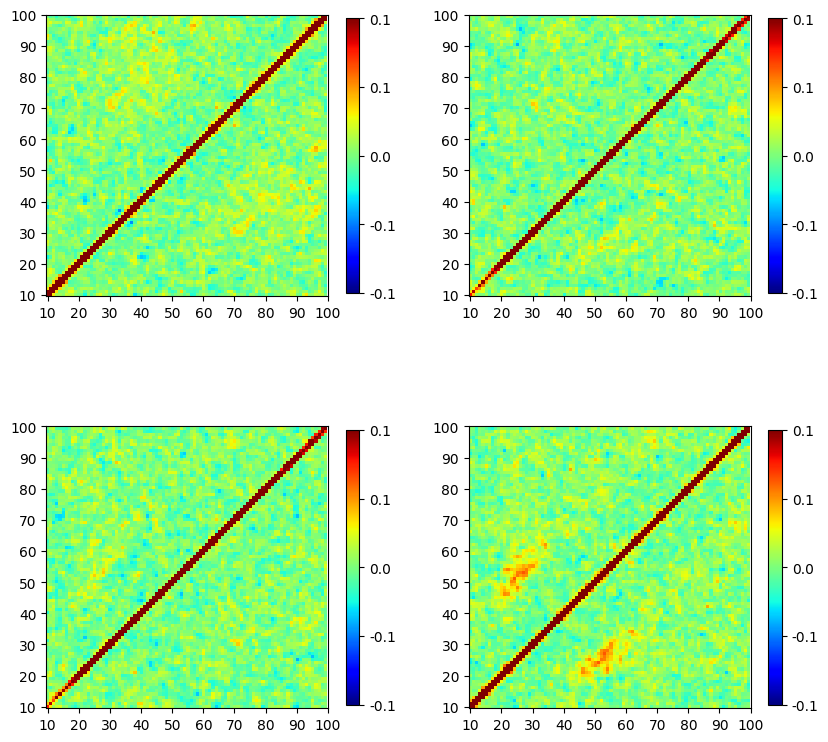

In [30]:
plt.figure(dpi=100, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        hhtools.imshow_xy(psd_corr_mat[i][j], x=fpsd, y=fpsd, cmap="jet", vmin=-0.1, vmax=0.1, interpolation="none")
        plt.axis("square")
        ft = np.arange(flim[0], flim[1]+5, 10)
        plt.xticks(ft); plt.yticks(ft)
        cbar = plt.colorbar(shrink=0.8, format=lambda x, pos: "{:.1f}".format(x))
        cbar.ax.locator_params(nbins=5)
plt.show()

In [55]:
nid

1799